In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import json
import logging
import re
from tqdm.notebook import tqdm
from tf_keras.utils import pad_sequences
from transformers import AutoTokenizer

from transformers import TFDistilBertForTokenClassification
from tf_keras.src.callbacks import ModelCheckpoint, EarlyStopping


#Named-Entity Recogniton to Process to gather skills in Resumes


### 1 - Dataset Cleaning

At this point of the process we will load the dataset and clean it. The dataset is a JSON file that contains the resumes of different individuals. The resumes are annotated with named entities such as 'Skills', 'Degree', 'Companies worked at', 'Designation', 'Email', 'Location', 'Name', 'College Name', 'Years of Experience', 'Graduation Year', 'Rewards and Achievements', 'Certifications', 'Links', 'Training', 'Projects', 'College Name', 'UNKNOWN'.

In [2]:
# Getting the dataset
df_data = pd.read_json("./data/Resumes.json", lines=True)
df_data = df_data.drop(['extras'], axis=1)
df_data['content'] = df_data['content'].str.replace("\n", " ")

In [3]:
#A little look at the dataset
df_data.head()

,content,annotation
0,Abhishek Jha Application Development Associate...,"[{'label': ['Skills'], 'points': [{'start': 12..."
1,Afreen Jamadar Active member of IIIT Committee...,"[{'label': ['Email Address'], 'points': [{'sta..."
2,"Akhil Yadav Polemaina Hyderabad, Telangana - E...","[{'label': ['Skills'], 'points': [{'start': 37..."
3,Alok Khandai Operational Analyst (SQL DBA) Eng...,"[{'label': ['Skills'], 'points': [{'start': 80..."
4,Ananya Chavan lecturer - oracle tutorials Mum...,"[{'label': ['Degree'], 'points': [{'start': 20..."


In [4]:
#Looking into the annotations that we are going to work with
df_data.iloc[0]['annotation']

[{'label': ['Skills'],
  'points': [{'start': 1295,
    'end': 1621,
    'text': '\n• Programming language: C, C++, Java\n• Oracle PeopleSoft\n• Internet Of Things\n• Machine Learning\n• Database Management System\n• Computer Networks\n• Operating System worked on: Linux, Windows, Mac\n\nNon - Technical Skills\n\n• Honest and Hard-Working\n• Tolerant and Flexible to Different Situations\n• Polite and Calm\n• Team-Player'}]},
 {'label': ['Skills'],
  'points': [{'start': 993,
    'end': 1153,
    'text': 'C (Less than 1 year), Database (Less than 1 year), Database Management (Less than 1 year),\nDatabase Management System (Less than 1 year), Java (Less than 1 year)'}]},
 {'label': ['College Name'],
  'points': [{'start': 939, 'end': 956, 'text': 'Kendriya Vidyalaya'}]},
 {'label': ['College Name'],
  'points': [{'start': 883, 'end': 904, 'text': 'Woodbine modern school'}]},
 {'label': ['Graduation Year'],
  'points': [{'start': 856, 'end': 860, 'text': '2017\n'}]},
 {'label': ['College 

In [5]:
# Merging the intervals of the entities
def merge_intervals(intervals):
    sorted_by_lower_bound = sorted(intervals, key=lambda tup: tup[0])
    merged = []

    for higher in sorted_by_lower_bound:
        if not merged:
            merged.append(higher)
        else:
            lower = merged[-1]
            if higher[0] <= lower[1]:
                if lower[2] is higher[2]:
                    upper_bound = max(lower[1], higher[1])
                    merged[-1] = (lower[0], upper_bound, lower[2])
                else:
                    if lower[1] > higher[1]:
                        merged[-1] = lower
                    else:
                        merged[-1] = (lower[0], higher[1], higher[2])
            else:
                merged.append(higher)
    return merged

In [6]:
# Extracting the entities from the annotations
def get_entities(df):
    
    entities = []
    
    for i in range(len(df)):
        entity = []
    
        for annot in df['annotation'][i]:
            try:
                ent = annot['label'][0]
                start = annot['points'][0]['start']
                end = annot['points'][0]['end'] + 1
                entity.append((start, end, ent))
            except:
                pass
    
        entity = merge_intervals(entity)
        entities.append(entity)
    
    return entities

In [7]:
#A look into the annotations and entities we extracted, with this we know what are the entities we want to extract and the positions of the entities in the document.
df_data['entities'] = get_entities(df_data)
df_data.head()

,content,annotation,entities
0,Abhishek Jha Application Development Associate...,"[{'label': ['Skills'], 'points': [{'start': 12...","[(0, 12, Name), (13, 46, Designation), (49, 58..."
1,Afreen Jamadar Active member of IIIT Committee...,"[{'label': ['Email Address'], 'points': [{'sta...","[(0, 14, Name), (62, 68, Location), (104, 148,..."
2,"Akhil Yadav Polemaina Hyderabad, Telangana - E...","[{'label': ['Skills'], 'points': [{'start': 37...","[(0, 21, Name), (22, 31, Location), (65, 117, ..."
3,Alok Khandai Operational Analyst (SQL DBA) Eng...,"[{'label': ['Skills'], 'points': [{'start': 80...","[(0, 12, Name), (13, 51, Designation), (54, 60..."
4,Ananya Chavan lecturer - oracle tutorials Mum...,"[{'label': ['Degree'], 'points': [{'start': 20...","[(0, 13, Name), (14, 22, Designation), (24, 41..."


In [8]:
# Form the json dataset we convert the data into a better format for training.
def convert_json_data_to_training_data(json_file_path):
    try:
        training_data = []
        lines=[]
        with open(json_file_path, 'r', encoding='utf-8') as f:
            lines = f.readlines()

        for line in lines:
            data = json.loads(line)
            text = data['content'].replace("\n", " ")
            entities = []
            data_annotations = data['annotation']
            if data_annotations is not None:
                for annotation in data_annotations:
                    #only a single point in text annotation.
                    point = annotation['points'][0]
                    labels = annotation['label']
                    # handle both list of labels or a single label.
                    if not isinstance(labels, list):
                        labels = [labels]

                    for label in labels:
                        point_start = point['start']
                        point_end = point['end']
                        point_text = point['text']
                        
                        lstrip_diff = len(point_text) - len(point_text.lstrip())
                        rstrip_diff = len(point_text) - len(point_text.rstrip())
                        if lstrip_diff != 0:
                            point_start = point_start + lstrip_diff
                        if rstrip_diff != 0:
                            point_end = point_end - rstrip_diff
                        entities.append((point_start, point_end + 1 , label))
            training_data.append((text, {"entities" : entities}))
        return training_data
    except Exception as e:
        logging.exception("Unable to process " + json_file_path + "\n" + "error = " + str(e))
        return None

In [9]:
def trim_entity_spans(data: list) -> list:
    invalid_span_tokens = re.compile(r'\s')

    cleaned_data = []
    for text, annotations in data:
        entities = annotations['entities']
        valid_entities = []
        for start, end, label in entities:
            valid_start = start
            valid_end = end
            while valid_start < len(text) and invalid_span_tokens.match(
                    text[valid_start]):
                valid_start += 1
            while valid_end > 1 and invalid_span_tokens.match(
                    text[valid_end - 1]):
                valid_end -= 1
            valid_entities.append([valid_start, valid_end, label])
        cleaned_data.append([text, {'entities': valid_entities}])
    return cleaned_data  

In [10]:
# Getting data and cleaning it 
data = trim_entity_spans(convert_json_data_to_training_data("./data/Resumes.json"))

In [11]:

def clean_dataset(data):
    cleanedDF = pd.DataFrame(columns=["setences_cleaned"])
    sum1 = 0
    for i in tqdm(range(len(data))):
        start = 0
        emptyList = ["Empty"] * len(data[i][0].split())
        numberOfWords = 0
        lenOfString = len(data[i][0])
        strData = data[i][0]
        strDictData = data[i][1]
        lastIndexOfSpace = strData.rfind(' ')
        for i in range(lenOfString):
            if (strData[i]==" " and strData[i+1]!=" "):
                for k,v in strDictData.items():
                    for j in range(len(v)):
                        entList = v[len(v)-j-1]
                        if (start>=int(entList[0]) and i<=int(entList[1])):
                            emptyList[numberOfWords] = entList[2]
                            break
                        else:
                            continue
                start = i + 1  
                numberOfWords += 1
            if (i == lastIndexOfSpace):
                for j in range(len(v)):
                        entList = v[len(v)-j-1]
                        if (lastIndexOfSpace>=int(entList[0]) and lenOfString<=int(entList[1])):
                            emptyList[numberOfWords] = entList[2]
                            numberOfWords += 1
        cleanedDF.loc[len(cleanedDF)] = [emptyList]
        sum1 = sum1 + numberOfWords
    return cleanedDF

In [12]:
#Cleaned dataset with the named-entities matched to the categories
cleanedDF = clean_dataset(data)

  0%|          | 0/220 [00:00<?, ?it/s]

Take a look at your cleaned dataset and the categories the named-entities are matched to, or 'tags'.

In [13]:
cleanedDF.head()

,setences_cleaned
0,"[Name, Name, Designation, Designation, Designa..."
1,"[Name, Name, Empty, Empty, Empty, Empty, Empty..."
2,"[Name, Name, Name, Empty, Empty, Empty, Empty,..."
3,"[Name, Name, Designation, Designation, Designa..."
4,"[Name, Name, Designation, Empty, Companies wor..."


### 2 - Padding and Generating Tags

Based on the entities in our dataset with generate a list of unique tags you will match the named-entities to.

In [14]:
# We create a list of unique tags and their ids
unique_tags = set(cleanedDF['setences_cleaned'].explode().unique())#pd.unique(cleanedDF['setences_cleaned'])#set(tag for doc in cleanedDF['setences_cleaned'].values.tolist() for tag in doc)
tag2id = {tag: id for id, tag in enumerate(unique_tags)}
id2tag = {id: tag for tag, id in tag2id.items()}

In [15]:
unique_tags

{'College Name',
 'Companies worked at',
 'Degree',
 'Designation',
 'Email Address',
 'Empty',
 'Graduation Year',
 'Location',
 'Name',
 'Skills',
 'UNKNOWN',
 'Years of Experience'}

We are going to create an array of tags from the cleaned dataset. Oftentimes, the input sequence can exceed the maximum length of a sequence the network can process, so  we make sure it can cut off to a desirable maximum length. And when the input sequence is shorter than the desired length, we append zeroes onto its end using this Keras padding API, We can find more information about it, here: https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/sequence/pad_sequences.

In [16]:
MAX_LEN = 512
labels = cleanedDF['setences_cleaned'].values.tolist()

tags = pad_sequences([[tag2id.get(l) for l in label] for label in labels],
                     maxlen=MAX_LEN, value=tag2id["Empty"], padding="post",
                     dtype="long", truncating="post")

In [17]:
#At this point we have our tags
tags

array([[1, 1, 6, ..., 5, 5, 5],
       [1, 1, 5, ..., 5, 5, 5],
       [1, 1, 1, ..., 5, 9, 5],
       ...,
       [1, 1, 6, ..., 5, 5, 5],
       [1, 1, 6, ..., 5, 5, 5],
       [1, 1, 6, ..., 5, 5, 5]])

### 3 - Tokenize and Align Labels with hugging face Library

Before feeding the texts to a Transformer model, We need to apply a tokenizer to tokenize our elements. It is crucial that the tokenizer we are using match the Transformer model type. We are going to use "distilbert-base-cased", It can be found here: https://huggingface.co/transformers/model_doc/distilbert.html

In [18]:
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-cased")

Tokenizers like Bert can often split words into subwords, creating a work into subtokens instead of an unique token. For that reason we must align the tags with our labels converted into token. 

In [19]:
label_all_tokens = True
def tokenize_and_align_labels(tokenizer, examples, tags):
    tokenized_inputs = tokenizer(examples, truncation=True, is_split_into_words=False, padding='max_length', max_length=512)
    labels = []
    for i, label in enumerate(tags):
        word_ids = tokenized_inputs.word_ids(batch_index=i)
        previous_word_idx = None
        label_ids = []
        for word_idx in word_ids:
            # Special tokens have a word id that is None.             
            if word_idx is None:                
                label_ids.append(0)
            # We set the label for the first token of each word.
            elif word_idx != previous_word_idx:
                label_ids.append(label[word_idx])                        
            else:
                label_ids.append(label[word_idx] if label_all_tokens else 0)           
            previous_word_idx = word_idx

        labels.append(label_ids)

    tokenized_inputs["labels"] = labels
    return tokenized_inputs

In [20]:
#Now with the tokenization of the elements we proceed to split our dataset into test and train data.
tokenized_data = tokenize_and_align_labels(tokenizer, df_data['content'].values.tolist(), tags)
train_input_ids = tokenized_data['input_ids'][:200] 
train_labels = tokenized_data['labels'][:200]
train_dataset = tf.data.Dataset.from_tensor_slices((
    train_input_ids,
    train_labels
))

validation_input_ids = tokenized_data['input_ids'][201:]
validation_labels = tokenized_data['labels'][201:]

validation_dataset = tf.data.Dataset.from_tensor_slices((
    validation_input_ids,
    validation_labels
))

We proceed to create our model from a pretrained model, as mentioned early we selected "distilbert-base-cased" as our tokenizer and we are going to use it to identify skill in the resumes. 

### 4 - Getting and training pre - trained model  

In [21]:
model = TFDistilBertForTokenClassification.from_pretrained('distilbert-base-cased', num_labels=len(unique_tags))

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForTokenClassification: ['vocab_transform.bias', 'vocab_projector.bias', 'vocab_transform.weight', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias']
- This IS expected if you are initializing TFDistilBertForTokenClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForTokenClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForTokenClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able t

In [22]:
# Adam optimizer was selected with a learning rate of 1e-5, Adam was selected because for what it has to offer it's really good a memory efficiency
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5)
# SparseCategoricalCrossentropy was selected because it works really were for multi class classification
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

#We compile the model with all the hyperparameters and add checkpoint and early stopped
checkpoint_cb = ModelCheckpoint("./NER_Resumes_model.keras", monitor='accuracy', save_best_only=True, mode='min')
#Patience is set to 3, meaning that the model will stop training if the loss function does not improve after 3 epochs
early_stopping_cb = EarlyStopping(patience=5, restore_best_weights=True, monitor='accuracy', mode='min')

model.compile(optimizer=optimizer, loss=loss_fn, metrics=['accuracy'])
#We proceed with the training, a small batch_size was selected at first depending on the performance, we will apply hyperparameter tuning . 
model.fit(train_dataset, epochs=10, batch_size=4, callbacks=[checkpoint_cb, early_stopping_cb])

Epoch 1/10
Cause: for/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: for/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert



200/200 [==============================] - ETA: 0s - loss: 0.5632 - accuracy: 0.8852

D:\Developments\Python\DeepLearning\NER_Resume\.venv\lib\site-packages\transformers\generation\tf_utils.py:465: UserWarning: `seed_generator` is deprecated and will be removed in a future version.
  warnings.warn("`seed_generator` is deprecated and will be removed in a future version.", UserWarning)


200/200 [==============================] - 257s 1s/step - loss: 0.5632 - accuracy: 0.8852
Epoch 2/10
200/200 [==============================] - 283s 1s/step - loss: 0.3783 - accuracy: 0.9127
Epoch 3/10
200/200 [==============================] - 216s 1s/step - loss: 0.3411 - accuracy: 0.9182
Epoch 4/10
200/200 [==============================] - 215s 1s/step - loss: 0.3191 - accuracy: 0.9232
Epoch 5/10
200/200 [==============================] - 214s 1s/step - loss: 0.2952 - accuracy: 0.9277
Epoch 6/10
200/200 [==============================] - 215s 1s/step - loss: 0.2773 - accuracy: 0.9316


### 5 - Evaluation of the model 

In [23]:
#Before the evaluation, We proceed to save the model our model.
model.save("NER_Resume.keras")

D:\Developments\Python\DeepLearning\NER_Resume\.venv\lib\site-packages\transformers\generation\tf_utils.py:465: UserWarning: `seed_generator` is deprecated and will be removed in a future version.
  warnings.warn("`seed_generator` is deprecated and will be removed in a future version.", UserWarning)


For the evaluation we need to compare the true labels of the validation data and compare them with the predictions of the model.  

In [33]:
# Getting the true labels
true_labels = [[id2tag.get(true_index, "Empty") for true_index in validation_labels[i]] for i in range(len(validation_labels))]
np.array(true_labels).shape

(19, 512)

In [34]:
# Make a prediction over the validation dataset 
output = model.predict(validation_dataset)
predictions = np.argmax(output['logits'].reshape(19, -1, 12), axis=-1)
predictions.shape

19/19 [==============================] - 3s 173ms/step


(19, 512)

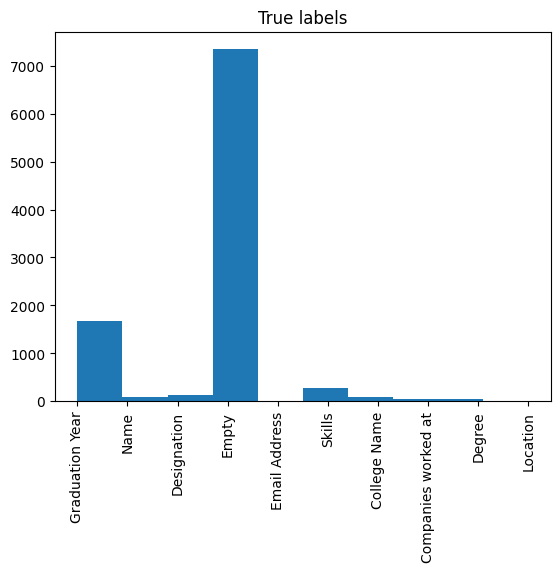

In [35]:
from matplotlib import pyplot as plt 
p = plt.hist(np.array(true_labels).flatten())
plt.xticks(rotation='vertical')
plt.title('True labels')
plt.show()

In [36]:
from collections import Counter
Counter(np.array(true_labels).flatten())

Counter({'Empty': 7344,
         'Graduation Year': 1683,
         'Skills': 283,
         'Designation': 136,
         'Name': 93,
         'College Name': 83,
         'Degree': 48,
         'Companies worked at': 47,
         'Email Address': 7,
         'Location': 4})

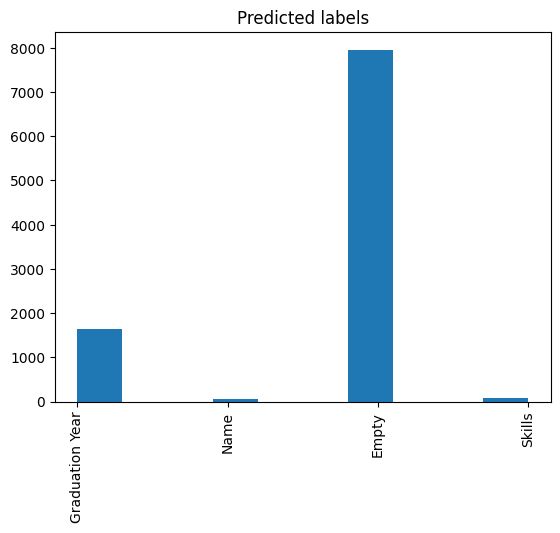

In [37]:
pred_labels = [[id2tag.get(index, "Empty") for index in predictions[i]] for i in range(len(predictions))]
p = plt.hist(np.array(pred_labels).flatten())
plt.xticks(rotation='vertical')
plt.title('Predicted labels')
plt.show()

In [38]:
Counter(np.array(pred_labels).flatten())

Counter({'Empty': 7960, 'Graduation Year': 1629, 'Skills': 82, 'Name': 57})

### 6 - Conclusion
Looking into the result has reveal a issue with our model, The is an issue with class imbalance, The Empty class is the most common class in the dataset, This is a common issue in NER tasks, and it can be solved by using techniques such as oversampling, undersampling, or class weights.
This is something that we need to look into the model in the future, and improve the data cleaning process to reduce the amount of empty classes. 